In [7]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
# import utils
import os
%matplotlib inline

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Input, Dropout,Flatten, Conv2D
from tensorflow.keras.layers import BatchNormalization, Activation, MaxPooling2D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import GlobalAveragePooling2D


from IPython.display import SVG, Image
from livelossplot import PlotLossesKerasTF
from livelossplot import PlotLossesKeras
import tensorflow as tf
print("Tensorflow version:", tf.__version__)

Tensorflow version: 2.2.1


In [2]:
img_size = 48
batch_size = 64

datagen_train = ImageDataGenerator(horizontal_flip=True)
train_generator = datagen_train.flow_from_directory('train/',
                                                    target_size = (img_size, img_size),
                                                    color_mode = 'grayscale',
                                                    batch_size = batch_size,
                                                    class_mode = 'categorical',
                                                    shuffle = True)

datagen_validation = ImageDataGenerator(horizontal_flip=True)
validation_generator = datagen_train.flow_from_directory('test/',
                                                    target_size = (img_size, img_size),
                                                    color_mode = 'grayscale',
                                                    batch_size = batch_size,
                                                    class_mode = 'categorical')

Found 28708 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [3]:
model = Sequential()

# Conv Block 1
model.add(Conv2D(64, (3,3), padding='same', input_shape=(48,48,1)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

# Conv Block 2
model.add(Conv2D(128,(5,5), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

# Conv Block 3
model.add(Conv2D(512,(3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

# Conv Block 3
model.add(Conv2D(512,(3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Flatten())

# Fully connected Block 1
model.add(Dense(256))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))

# Fully connected Block 2
model.add(Dense(512))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))

model.add(Dense(7, activation='softmax'))

opt = Adam(lr=0.0005)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 48, 48, 64)        640       
_________________________________________________________________
batch_normalization (BatchNo (None, 48, 48, 64)        256       
_________________________________________________________________
activation (Activation)      (None, 48, 48, 64)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 24, 24, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 24, 24, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 24, 24, 128)       204928    
_________________________________________________________________
batch_normalization_1 (Batch (None, 24, 24, 128)       5

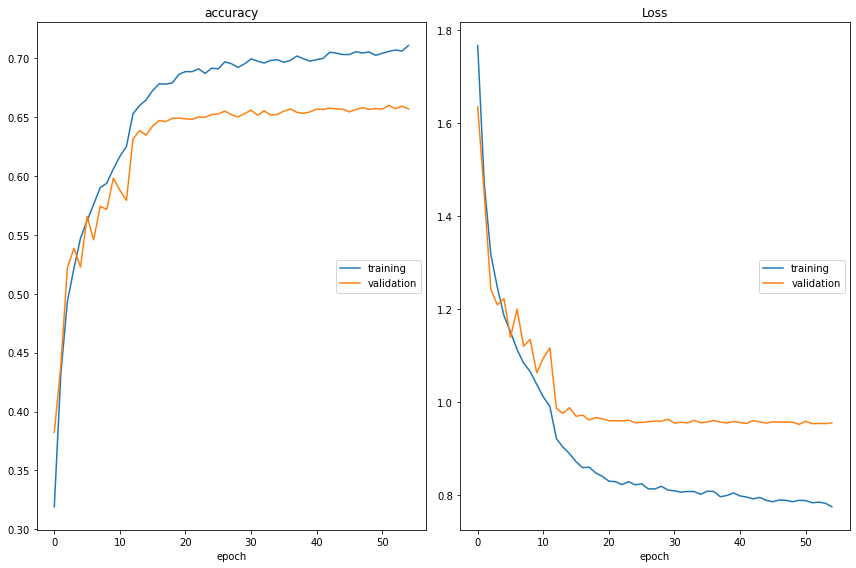

accuracy
	training         	 (min:    0.319, max:    0.711, cur:    0.711)
	validation       	 (min:    0.382, max:    0.660, cur:    0.657)
Loss
	training         	 (min:    0.775, max:    1.768, cur:    0.775)
	validation       	 (min:    0.952, max:    1.636, cur:    0.955)

Epoch 00055: saving model to model_weights.h5
448/448 [==============================] - 391s 874ms/step - loss: 0.7749 - accuracy: 0.7110 - val_loss: 0.9555 - val_accuracy: 0.6571 - lr: 1.0000e-05


In [10]:
epochs = 55
steps_per_epoch= train_generator.n//train_generator.batch_size
validation_steps = validation_generator.n//validation_generator.batch_size

checkpoint = ModelCheckpoint("model_weights.h5",monitor='val_accuracy',
                            save_weights_only=True, mode='max',verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss' , factor=0.1, patience=2, min_lr=0.00001,model='auto')

callbacks = [PlotLossesKerasTF(), checkpoint, reduce_lr]

history = model.fit(
        x= train_generator,
        steps_per_epoch=steps_per_epoch,
        epochs=epochs,
        validation_data=validation_generator,
        validation_steps=validation_steps,
        callbacks=callbacks
)

In [11]:
## Represent Model in JSON String:
model_json = model.to_json()
with open('model_2.json', 'w') as json_file:
    json_file.write(model_json)

Accuracy of the model is 71.10%

In [45]:
from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay
import sklearn.metrics as metrics

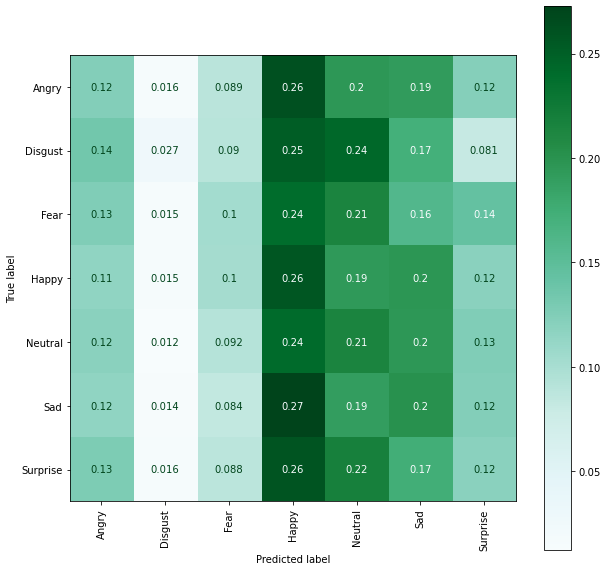

In [49]:
cm = metrics.confusion_matrix(validation_generator.classes, 
                              y_pred, 
                              normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, 
                              display_labels=target_names)
fig, ax = plt.subplots(figsize=(10, 10))
disp = disp.plot(xticks_rotation='vertical', ax=ax, cmap='BuGn')
plt.show()

In [37]:
for expression in os.listdir("train/"):
    print(str(len(os.listdir("train/" + expression))) + " " + expression + " images")

7214 happy images
4830 sad images
4097 fear images
3171 surprise images
4965 neutral images
3995 angry images
436 disgust images


Class imbalance issue is clearly affecting the accuracy of the model. Based of confusion matrix we can see that Disgust (most underrepresented class) is the worst performing. Model is having a hard time detecting this emotion. In contrast, highest amount of data is for Happy emotion class (relatively overrepresented) and the model thinks that most of the emotions are happy. The trend can be observed with number of data points and accuracy of each emotion.

Interesting to note is that model correctly recognizes `suprise` through the camera if you place your hand on your cheeks. Otherwise, it will conclude the emotion as `neutral`.